In [4]:
# Importing kaggle 

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
# Import datasets directly from Kaggle
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [00:06<00:00, 230MB/s]
100% 1.06G/1.06G [00:06<00:00, 185MB/s]


In [6]:
# Extract the images from zip file
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
# Import all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D,Dropout,MaxPooling2D,Flatten,BatchNormalization,Dense

In [8]:
# Segmenting training and test data

train_ds = keras.utils.image_dataset_from_directory('/content/train',
                                                   labels='inferred',
                                                   label_mode='int',
                                                   batch_size=32,
                                                   image_size=(256,256))

test_ds = keras.utils.image_dataset_from_directory('/content/test',
                                                   labels='inferred',
                                                   label_mode='int',
                                                   batch_size=32,
                                                   image_size=(256,256))

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [9]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
def process(image,label):
  image = tf.cast(image/255.,tf.float32)
  return image,label

In [11]:
train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

In [12]:
# Import the libraries that is requied to read the images
import cv2
import os

In [13]:
# reading all the images with path from the drive
cats = []
dogs = []
for dirname, _, filenames in os.walk('/content/train/cats'):
    for filename in filenames:
        path = '/content/train/cats/'+filename
        cats.append(path)
for dirname, _, filenames in os.walk('/content/train/dogs'):
    for filename in filenames:
        path = '/content/train/dogs/'+filename
        dogs.append(path)

In [14]:
# Creating a dogs and cat path in to  a dataframe
image_df = pd.DataFrame({'cat_images':cats,'dog_images':dogs})

In [15]:
image_df.head()

cat_images                         dog_images
0   /content/train/cats/cat.6361.jpg   /content/train/dogs/dog.5071.jpg
1   /content/train/cats/cat.5600.jpg  /content/train/dogs/dog.10512.jpg
2   /content/train/cats/cat.6739.jpg   /content/train/dogs/dog.7581.jpg
3   /content/train/cats/cat.1138.jpg  /content/train/dogs/dog.10666.jpg
4  /content/train/cats/cat.12009.jpg   /content/train/dogs/dog.6216.jpg

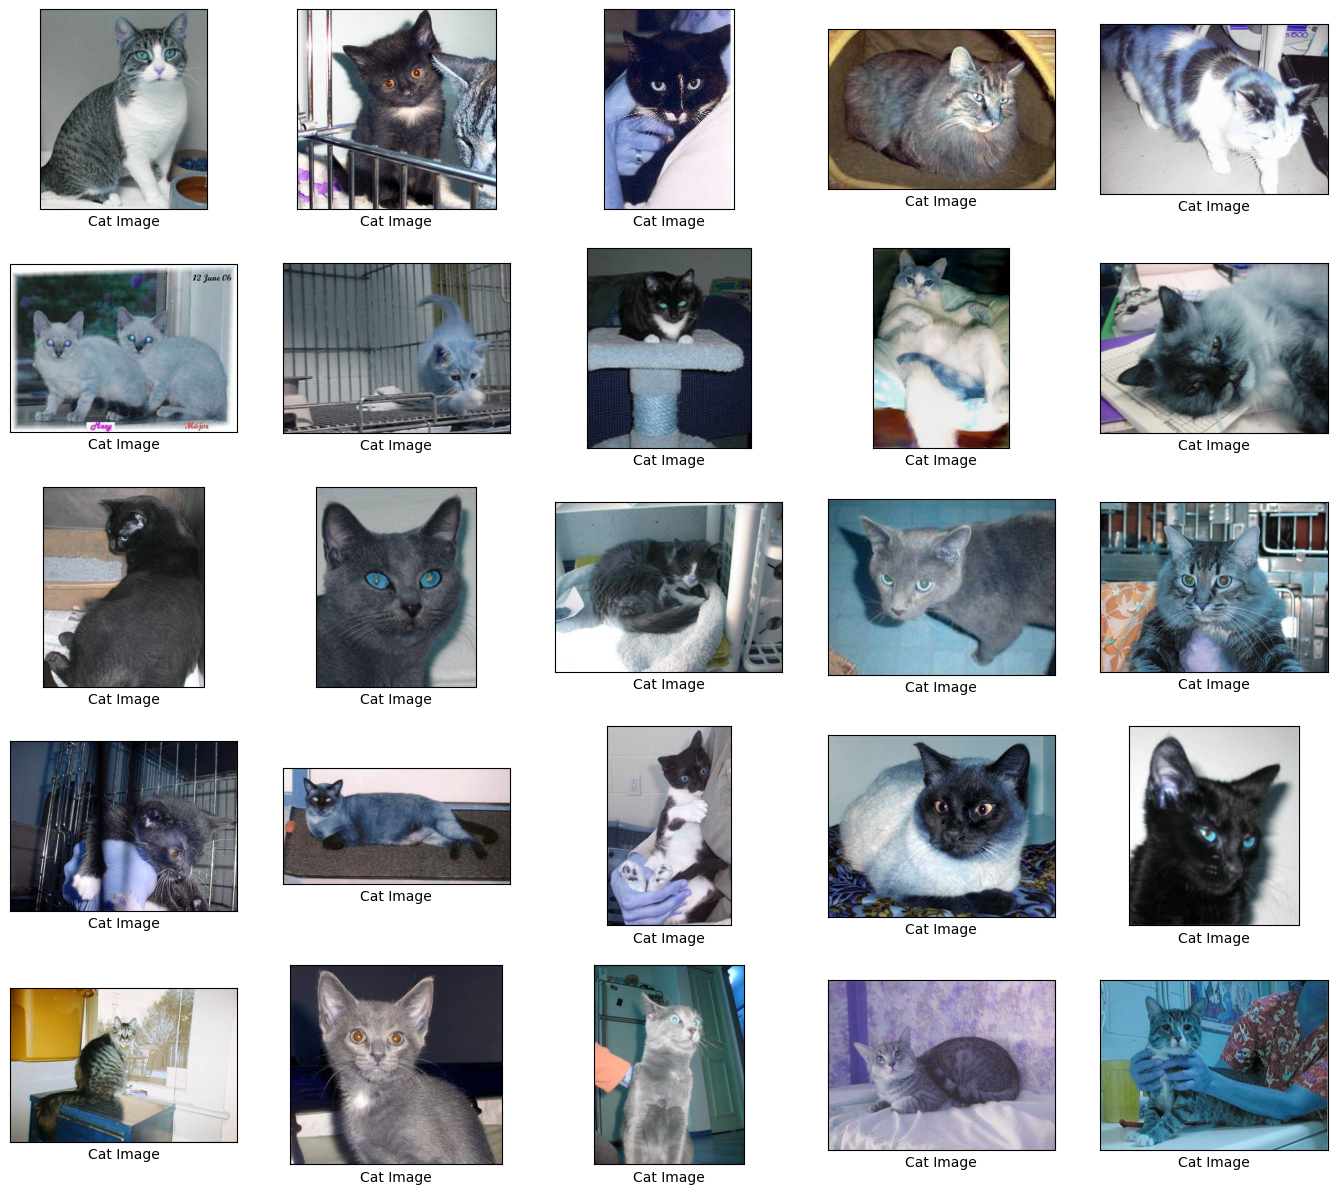

In [16]:
# Plot the cat images
fig = plt.figure(figsize=(17,15))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  plt.imshow(cv2.imread(image_df.cat_images.iloc[i]))
  plt.xlabel('Cat Image')
plt.show()

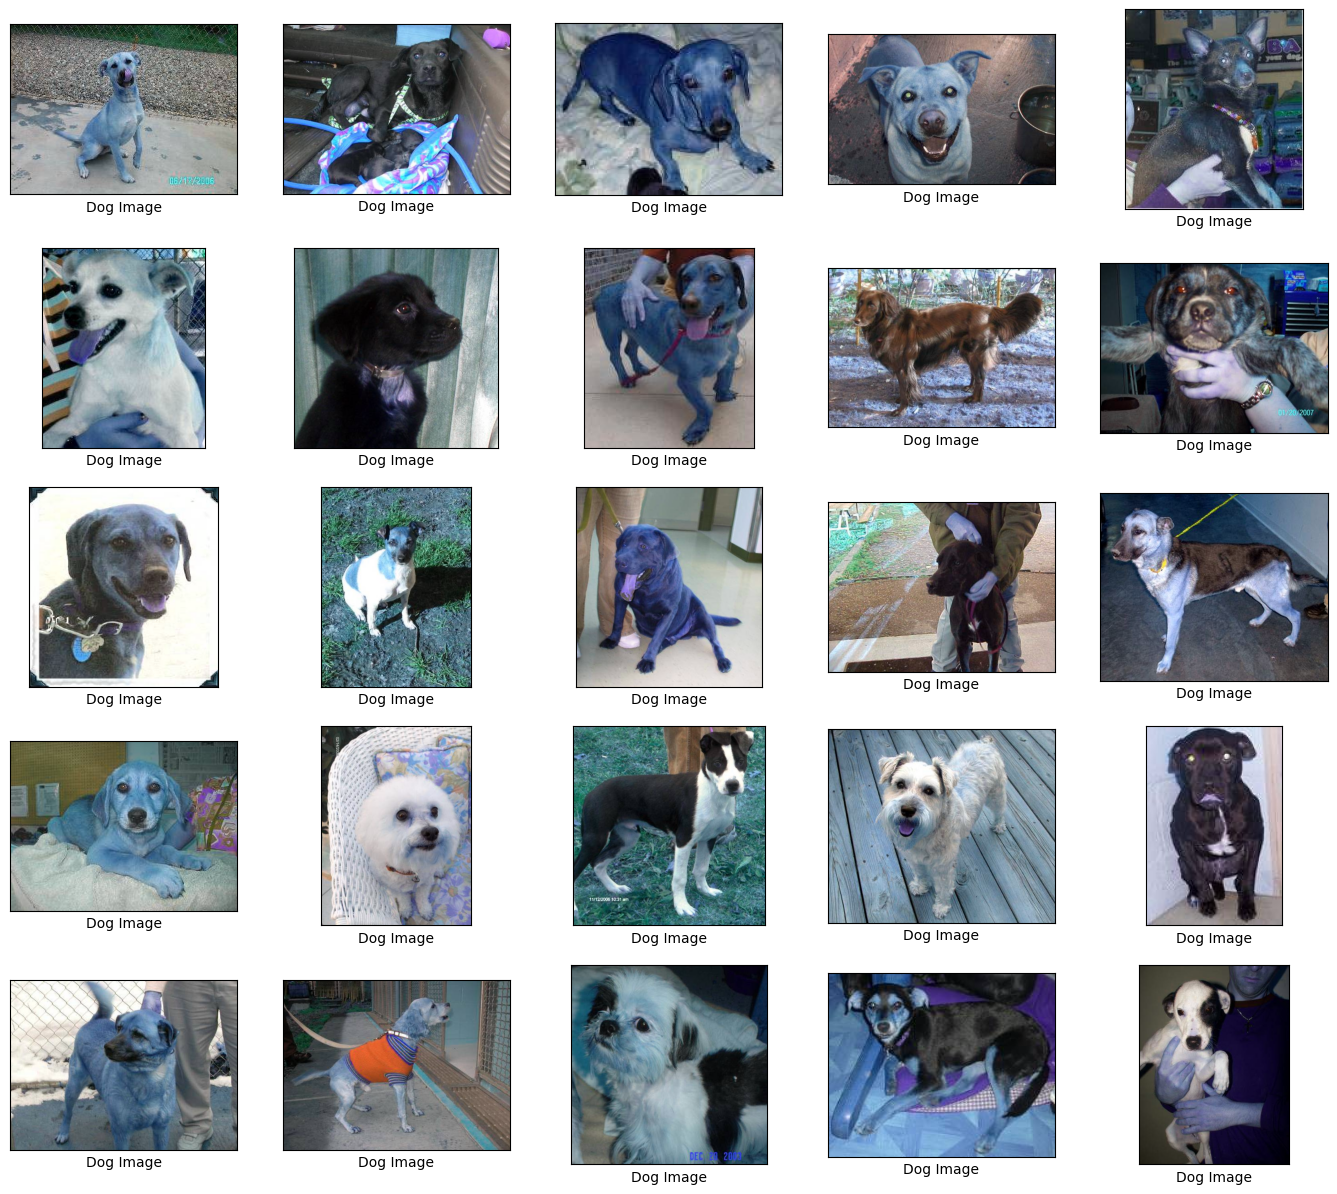

In [17]:
# Plot the dog images
fig = plt.figure(figsize=(17,15))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  plt.imshow(cv2.imread(image_df.dog_images.iloc[i]))
  plt.xlabel('Dog Image')
plt.show()

# Building a CNN Model

#Alex Net Model

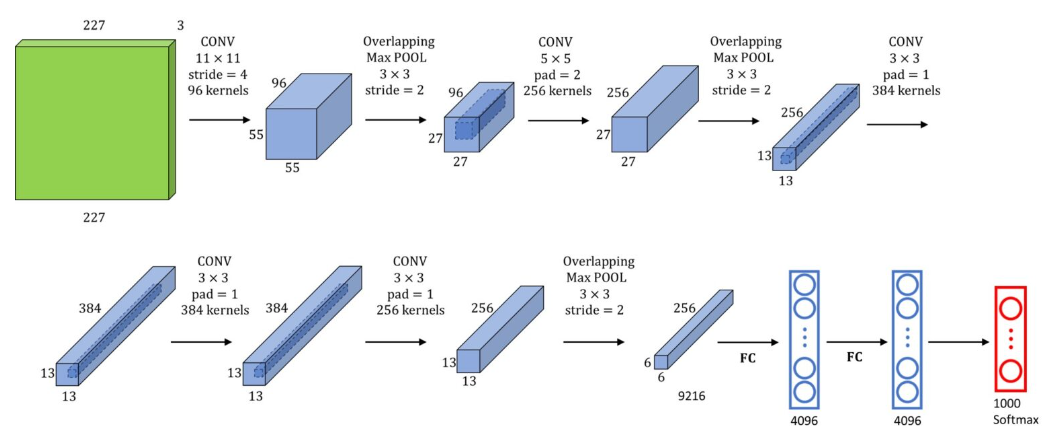

In [18]:
# Bulding a Alexnet model
model = Sequential()
model.add(Conv2D(96,kernel_size=(11,11),padding='valid',strides=4,activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='valid'))

model.add(Conv2D(256,kernel_size=(5,5),padding='same',activation='relu')) #padding = 2
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='valid'))

model.add(Conv2D(384,kernel_size=(3,3),padding='same',activation='relu')) #padding = 1
model.add(BatchNormalization())

model.add(Conv2D(384,kernel_size=(3,3),padding='same',activation='relu')) #padding = 1
model.add(BatchNormalization())

model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu')) #padding = 1
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(9216,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.30))

model.add(Dense(1,activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                        

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [21]:
train_data = ImageDataGenerator(
    rotation_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [22]:
train_data_generator = train_data.flow_from_directory('/content/train',target_size=(256,256),batch_size=10,class_mode='binary')

Found 20000 images belonging to 2 classes.


In [23]:
validation_data = ImageDataGenerator()
validation_data_generator = train_data.flow_from_directory('/content/test',target_size=(256,256),batch_size=10,class_mode='binary')

Found 5000 images belonging to 2 classes.


In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
history=model.fit(train_data_generator, validation_data=validation_data_generator, epochs=20,batch_size=64)

Epoch 1/20
2000/2000 [==============================] - 473s 226ms/step - loss: 1.0682 - accuracy: 0.5213 - val_loss: 0.7054 - val_accuracy: 0.5210
Epoch 2/20
2000/2000 [==============================] - 450s 225ms/step - loss: 0.7327 - accuracy: 0.5123 - val_loss: 0.6941 - val_accuracy: 0.5196
Epoch 3/20
2000/2000 [==============================] - 440s 220ms/step - loss: 0.7084 - accuracy: 0.5404 - val_loss: 0.9198 - val_accuracy: 0.5050
Epoch 4/20
2000/2000 [==============================] - 430s 215ms/step - loss: 0.7070 - accuracy: 0.5234 - val_loss: 0.6819 - val_accuracy: 0.5480
Epoch 5/20
2000/2000 [==============================] - 429s 215ms/step - loss: 0.6931 - accuracy: 0.5681 - val_loss: 0.6534 - val_accuracy: 0.6238
Epoch 6/20
2000/2000 [==============================] - 427s 214ms/step - loss: 0.6798 - accuracy: 0.5906 - val_loss: 0.7100 - val_accuracy: 0.5228
Epoch 7/20
2000/2000 [==============================] - 434s 217ms/step - loss: 0.6447 - accuracy: 0.6382 - val_

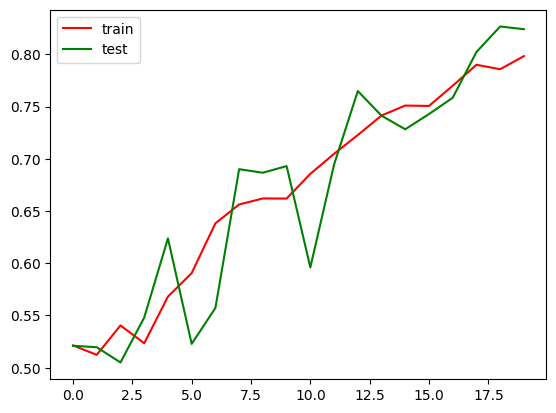

In [26]:
# Plotting accuracy and validation accuracy
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='green',label='test')
plt.legend()
plt.show()

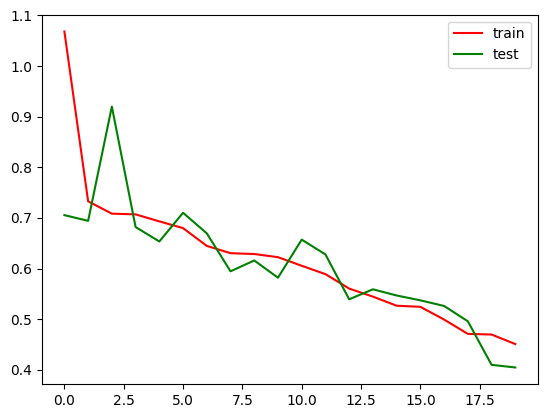

In [27]:
# plotting loss and validation loss
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='green',label='test')
plt.legend()
plt.show()

In [ ]:
# Bulding a Alexnet model
model1 = Sequential()
model1.add(Conv2D(96,kernel_size=(11,11),padding='valid',strides=4,activation='relu',input_shape=(256,256,3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='valid'))

model1.add(Conv2D(256,kernel_size=(5,5),padding='same',activation='relu')) #padding = 2
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='valid'))

model1.add(Conv2D(384,kernel_size=(3,3),padding='same',activation='relu')) #padding = 1
model1.add(BatchNormalization())

model1.add(Conv2D(384,kernel_size=(3,3),padding='same',activation='relu')) #padding = 1
model1.add(BatchNormalization())

model1.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu')) #padding = 1
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='valid'))

model1.add(Flatten())


model1.add(Dense(4096,activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(4096,activation='relu'))
model1.add(Dropout(0.30))

model1.add(Dense(1,activation='sigmoid'))

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 62, 62, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history1=model1.fit(train_ds, validation_data=test_ds, epochs=10,batch_size=64)

Epoch 1/10
625/625 [==============================] - 70s 101ms/step - loss: 1.2413 - accuracy: 0.5806 - val_loss: 0.7092 - val_accuracy: 0.6258
Epoch 2/10
625/625 [==============================] - 65s 103ms/step - loss: 0.6921 - accuracy: 0.6210 - val_loss: 0.6686 - val_accuracy: 0.5862
Epoch 3/10
625/625 [==============================] - 63s 100ms/step - loss: 0.6299 - accuracy: 0.6624 - val_loss: 0.6579 - val_accuracy: 0.6564
Epoch 4/10
625/625 [==============================] - 61s 96ms/step - loss: 0.5713 - accuracy: 0.7136 - val_loss: 0.7290 - val_accuracy: 0.6252
Epoch 5/10
625/625 [==============================] - 63s 100ms/step - loss: 0.4844 - accuracy: 0.7732 - val_loss: 0.5177 - val_accuracy: 0.7528
Epoch 6/10
625/625 [==============================] - 61s 97ms/step - loss: 0.4452 - accuracy: 0.7962 - val_loss: 0.4096 - val_accuracy: 0.8078
Epoch 7/10
625/625 [==============================] - 63s 100ms/step - loss: 0.3869 - accuracy: 0.8334 - val_loss: 0.5958 - val_accu

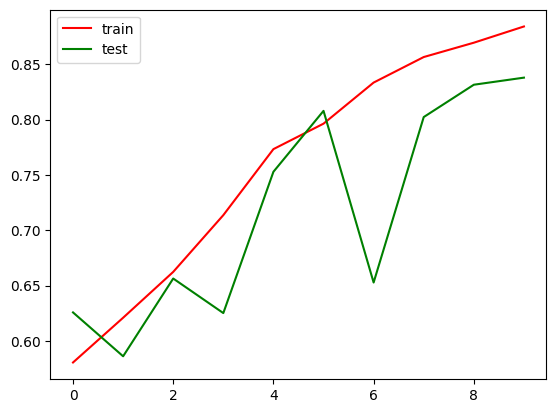

In [ ]:
# Plotting accuracy and validation accuracy
plt.plot(history1.history['accuracy'],color='red',label='train')
plt.plot(history1.history['val_accuracy'],color='green',label='test')
plt.legend()
plt.show()

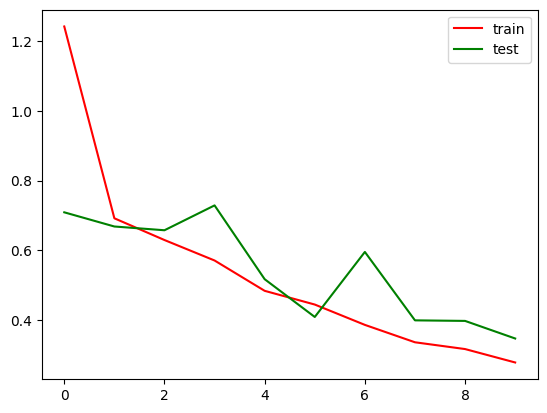

In [ ]:
# plotting loss and validation loss
plt.plot(history1.history['loss'],color='red',label='train')
plt.plot(history1.history['val_loss'],color='green',label='test')
plt.legend()
plt.show()